In [245]:
from lxml import html
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas_datareader as pdr
import pandas as pd
import datetime as dt
import os

## 1. Web crawler for the s&p500 companies list
use selenium and xpath selector to scrape the s&p500 companies list,
using Options() to avoid Chrome browser pop out.

In [2]:
def save_500_list():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

    ########## no web browser pop out ############
    chrome_options = Options()
    chrome_options.add_argument("--headless")  
    browser = webdriver.Chrome(chrome_options = chrome_options)
    browser.get(url)

    tree = html.fromstring(browser.page_source)
    result = tree.xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr/td[1]/a[1]/text()')

    browser.close()
    
    return result

In [3]:
names = save_500_list()
print(names[:10])

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD', 'AAP']


## 2. Store the companies list as a pickle file

In [4]:
with open('s&p500_tickers.pickle','wb') as file:
    pickle.dump(names, file)

## 3. Read the companies list from 's&p500_tickers.pickle' file, wait for download.

In [5]:
start_time = dt.datetime(2015,1,1) 
end_time = dt.datetime(2016,12,31)

with open('s&p500_tickers.pickle','rb') as file:
    all_list = pickle.load(file)

In [6]:
if not os.path.exists('s&p500_data'):
    os.makedirs('s&p500_data')

## 4. Use a for loop to download first 100 cpmpanies data 

In [7]:
def download_data():
    for symbol in all_list[:100]:
        if not os.path.exists('s&p500_data/{}.csv'.format(symbol)):
            temp_data = pdr.DataReader(ticker, 'yahoo', start_time, end_time)
            temp_data.to_csv('s&p500_data/{}.csv'.format(symbol))
        else:
            continue

In [8]:
download_data()

## 5. Compile all data into one pandas dataframe

In [230]:
def compile_data():
    main_df = pd.DataFrame()
    
    for count,symbol in enumerate(all_list[:100]):
        temp_df = pd.read_csv('s&p500_data/{}.csv'.format(symbol))
        temp_df.set_index('Date',inplace=True)
        
#         temp_df.drop(['High', 'Low', 'Close', 'Volume'], 1, inplace = True)
#         temp_df = pd.DataFrame(temp_df['Adj Close'] - temp_df.Open, columns = {symbol})
        temp_df.rename(columns = {'Adj Close': symbol}, inplace = True)
        temp_df.drop(['Open','High', 'Low', 'Close', 'Volume'], 1, inplace = True)
        
        if main_df is None:
            main_df = temp_df
        else:
            main_df = main_df.join(temp_df, how='outer')
    if count%10 == 0:
        print(count)
    return main_df

In [231]:
result_df = compile_data()
print(result_df.head())
# result_df.to_csv('s&p500_data.csv')

                   MMM        ABT       ABBV       ABMD        ACN       ATVI  \
Date                                                                            
2014-12-31  150.427399  41.626999  57.834881  38.060001  82.357475  19.563580   
2015-01-02  150.189392  41.516052  58.232586  37.310001  81.924049  19.544163   
2015-01-05  146.802200  41.525291  57.136696  37.070000  80.540825  19.272312   
2015-01-06  145.236755  41.053726  56.853886  36.130001  79.959869  18.913078   
2015-01-07  146.289551  41.386600  59.151722  37.279999  81.638191  18.505302   

                   AYI       ADBE   AMD         AAP     ...             CPB  \
Date                                                    ...                   
2014-12-31  138.711304  72.699997  2.67  158.376587     ...      150.427399   
2015-01-02  138.523163  72.339996  2.67  157.660675     ...      150.189392   
2015-01-05  135.195709  71.980003  2.66  155.582504     ...      146.802200   
2015-01-06  133.502304  70.529999  2.

In [233]:
# information = result_df.copy().as_matrix().T
# information /= information.std(axis=0)
information = result_df.copy().as_matrix()
information

array([[ 150.427399,   41.626999,   57.834881, ...,  150.427399,
         150.427399,  150.427399],
       [ 150.189392,   41.516052,   58.232586, ...,  150.189392,
         150.189392,  150.189392],
       [ 146.8022  ,   41.525291,   57.136696, ...,  146.8022  ,
         146.8022  ,  146.8022  ],
       ..., 
       [ 171.798813,   36.997528,   59.038383, ...,  171.798813,
         171.798813,  171.798813],
       [ 172.117203,   37.084652,   59.474514, ...,  172.117203,
         172.117203,  172.117203],
       [ 172.271561,   37.18145 ,   59.370216, ...,  172.271561,
         172.271561,  172.271561]])

In [234]:
edge_model = covariance.GraphLassoCV()
edge_model.fit(information)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

In [235]:
print(edge_model.covariance_.shape)

(100, 100)


In [236]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

In [237]:
len(labels)

100

In [238]:
symbols = np.array(names[:100])
# list(labels)
symbols

array(['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AMD',
       'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB',
       'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL',
       'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT',
       'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANDV',
       'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV',
       'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB',
       'AVY', 'BHGE', 'BLL', 'BAC', 'BK', 'BAX', 'BBT', 'BDX', 'BRK.B',
       'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX',
       'BHF', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB',
       'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CELG'],
      dtype='<U5')

In [239]:
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(symbols[labels == i])))

Cluster 1: ABT
Cluster 2: ABBV
Cluster 3: ATVI
Cluster 4: MMM, ABMD, ACN, AYI, ADBE, ALB, ALGN, ALL, GOOGL, GOOG, MO, AMZN, AEE, AAL, AEP, AXP, AIG, AMT, AWK, AMP, ABC, AME, AMGN, APH, APC, ADI, ANDV, ANSS, ANTM, AON, AOS, APA, AIV, AAPL, AMAT, APTV, ADM, ARNC, AJG, AIZ, T, ADSK, ADP, AZO, AVB, AVY, BHGE, BLL, BAC, BK, BAX, BBT, BDX, BRK.B, BBY, BIIB, BLK, HRB, BA, BKNG, BWA, BXP, BSX, BHF, BMY, AVGO, BF.B, CHRW, CA, COG, CDNS, CPB, COF, CAH, KMX, CCL, CAT, CBOE, CBRE, CBS, CELG
Cluster 5: AMD
Cluster 6: AAP
Cluster 7: AES
Cluster 8: AET
Cluster 9: AFL
Cluster 10: A
Cluster 11: APD
Cluster 12: AKAM
Cluster 13: ALK
Cluster 14: ARE
Cluster 15: ALLE
Cluster 16: AMG, ALXN, AGN, ADS
Cluster 17: LNT


In [270]:
node_position_model = manifold.LocallyLinearEmbedding()
#     n_components=2, eigen_solver='dense', n_neighbors=6)
embedding = node_position_model.fit_transform(information.T).T

In [271]:
embedding[1]

array([ 0.01762984,  0.00878661, -0.13869611, -0.29057818, -0.26718422,
        0.13894556,  0.01760083, -0.28952688,  0.41012424,  0.01758653,
        0.33968296, -0.21801154,  0.01820418,  0.14063466,  0.03712568,
       -0.14139569, -0.1236412 , -0.18188069, -0.26345053, -0.25777307,
        0.01807502, -0.28895965, -0.18509385,  0.02019745,  0.01987033,
        0.15018555,  0.01762984,  0.01762984,  0.01746149,  0.01746149,
        0.01746149,  0.01746149,  0.01746149,  0.01746149,  0.01746149,
        0.01746149,  0.01746149,  0.01746149,  0.01746149,  0.01746149,
        0.01746149,  0.01746149,  0.01746149,  0.01746149,  0.01746149,
        0.01746149,  0.01746149,  0.01746149,  0.01746149,  0.01746149,
        0.01746149,  0.01746149,  0.01746149,  0.0174876 ,  0.01746149,
        0.01748229,  0.01748215,  0.01748229,  0.01748229,  0.01746149,
        0.01746149,  0.01746149,  0.01746149,  0.01746149,  0.01746149,
        0.01746149,  0.01746149,  0.01746149,  0.01746149,  0.01

In [272]:
node_position_model

LocallyLinearEmbedding(eigen_solver='auto', hessian_tol=0.0001, max_iter=100,
            method='standard', modified_tol=1e-12, n_components=2,
            n_jobs=1, n_neighbors=5, neighbors_algorithm='auto',
            random_state=None, reg=0.001, tol=1e-06)

In [422]:
edge_model.precision_

array([[ 0.00703711,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.09619979, -0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.        , -0.        ,  0.05910411, ..., -0.        ,
        -0.        , -0.        ],
       ..., 
       [-0.        ,  0.        , -0.        , ...,  0.00703711,
        -0.        , -0.        ],
       [-0.        ,  0.        , -0.        , ..., -0.        ,
         0.00703711, -0.        ],
       [-0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        ,  0.00703711]])

[ 0.0462379   0.38122852  0.11168884  0.14376092  0.12182333  0.18190545
  0.07185812  0.0586939   0.17505534  0.08922577  0.14957041  0.08221371
  0.39455033  0.16467293  0.27427992  0.25361891  0.09039398  0.19403901
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782  0.04623782
  0.04623782  0.04623782  0.04623782  0.04623782  0

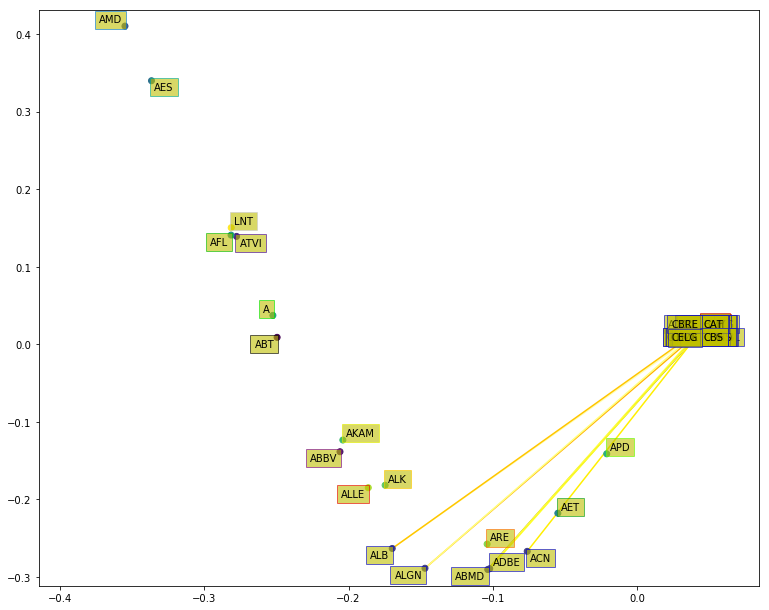

In [700]:
###############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
# plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], c=labels)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r)

print(values)
lc.set_array(values)
# lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='y',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())
plt.show()